#Rede Neural

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, show, clf

In [ ]:
# Garante reprodutibilidade
np.random.seed(42)

In [ ]:
# Para a Bruna conseguir rodar no PC dela ;)
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/AprendizadoMaquina/classification2.txt', header=None)

Mounted at /content/drive


In [ ]:
# df = pd.read_csv('classification2.txt', header=None)

In [ ]:
# Carrega o dataset (sem header)
# df = pd.read_csv("classification2.txt", header=None)

# Visualizar as primeiras linhas para confirmar formato (2 features + 1 label assumidos)
print("Head do dataframe:")
display(df.head())
print("Shape do dataframe:", df.shape)

Head do dataframe:


,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


Shape do dataframe: (118, 3)


# Construção da rede
Nesta parte criamos funções para inicializar camadas e montar a arquitetura.
- `make_new_layer(dout, din, sigma=0.2, bias=False)`: cria matriz de pesos uniformes.
- `make_network(dims)`: cria a lista de camadas com pesos e biases.
Observação: o parâmetro `bias` em make_new_layer não é utilizado para criar bias separado; biases são criadas explicitamente em 'make_network'.


In [ ]:
def make_new_layer(dout, din, sigma=0.2, bias=False):
    if bias:
        din += 1
    return np.random.uniform(-sigma, sigma, (dout, din))


def make_network(dims):
    net = []
    for i in range(len(dims) - 1):
        # w: (dims[i+1], dims[i])
        # b: (dims[i+1], 1)
        net.append({
            'w': make_new_layer(dims[i+1], dims[i]),
            'b': make_new_layer(dims[i+1], 1)
        })
    return net

# Exemplo de criação de rede
net = make_network([2, 50, 1])
print("Rede criada com", len(net), "camadas (excluíndo input).")
print("Shape w primeira camada:", net[0]['w'].shape, "shape b:", net[0]['b'].shape)

Rede criada com 2 camadas (excluíndo input).
Shape w primeira camada: (50, 2) shape b: (50, 1)


# Extração de entradas e rótulos e normalização
- Extrai as duas primeiras colunas como features (X) e a última como rótulo (y).
- Faz normalização (z-score) por coluna: (X - média) / desvio padrão.
Observação: no código original há duas normalizações (uma anterior e outra depois); apenas uma é necessária — eu mostro a normalização que será usada no treino.

In [ ]:
# X: todas as colunas exceto a última; y: última coluna
X = df.iloc[:, :-1].values  # assume 2 features
y = df.iloc[:, -1].values   # rótulos 0/1

# Computa média e desvio por coluna
m = np.mean(X, axis=0)
s = np.std(X, axis=0)
X = (X - m) / s  # normalização: Z-score

print("Shape X:", X.shape, "Shape y:", y.shape)
print("Médias (antes):", m)
print("Desvios (antes):", s)

Shape X: (118, 2) Shape y: (118,)
Médias (antes): [0.05477891 0.18310156]
Desvios (antes): [0.49454485 0.51753592]


# Funções de ativação
- Implementamos Sigmoid, ReLU e derivadas necessárias.
- O sigmoid usa np.clip para evitar overflow numérico em exp.
- Escolha a função de ativação definindo as variáveis `activation` e `derivative`.


In [ ]:
# ATIVAÇÕES E DERIVADAS
def sigmoid(z):
    # np.clip evita overflow numérico em exp
    return 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))

def deriv_sigmoid(a):
    # recebe a = sigmoid(z)
    return a * (1 - a)

def relu(z):
    return np.maximum(z, 0.0)

def deriv_relu(a):
    # retorna 1 onde a>0, 0 caso contrário
    return np.where(a > 0, 1.0, 0.0)

def tanh(z):
    # recebe a = tanh(z)
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def deriv_tanh(a):
    # recebe a = tanh(z)
    return 1 - a**2

# Configura ativação das camadas ocultas
activation = relu
derivative = deriv_relu


# Forward propagation
- Calcula saída da rede camada a camada.
- Armazena listas de ativações (a_list) e pré-ativação (z_list) para uso no backprop.
- Retorna: saída escalar, lista de ativacões, lista de z (pré-ativação).


In [ ]:
# FORWARD PROPAGATION
def forward_prop(x, net, get_z=False):
    """
    x: vetor (n_features,) ou (n_features, 1)
    net: lista de camadas
    get_z: se True retorna o z (pré-ativação) da última camada (útil p/ debugging)
    Retorna:
      - se get_z=False: (y_pred_scalar, a_list, z_list)
      - se get_z=True: z_last[0][0] (valor escalar do pré-ativação final)
    """
    # Garante que x tem formato coluna
    if len(x.shape) == 1:
        x = x.reshape(x.shape[0], 1)  # (n_features, 1)

    a_list = [x]  # a_0 = entrada
    z_list = [x]  # z_0 não é realmente z, mas este código inicializa assim (compatibilidade)

    L = len(net)
    for i, layer in enumerate(net):
        w, b = layer['w'], layer['b']
        x = np.dot(w, x) + b  # z = W*x + b
        z_list.append(np.array(x))  # armazenando pré-ativação

        if i < L - 1:
            # camadas ocultas -> aplica função de ativação escolhida
            x = activation(x)
        else:
            # última camada -> aplicamos sigmoid para probabilidade
            z = x
            x = sigmoid(x)

        a_list.append(x)  # ativações por camada

    if get_z:
        # retorna o pré-ativação escalar da última camada
        return z[0][0]

    # retorna: saída escalar (y_pred), lista de ativações, lista de z
    return x[0][0], a_list, z_list

# Backprop (gradientes)
- Implementa backprop classic (para todo o batch): acumula gradientes por exemplo e faz média.
- Usa a função `derivative` definida anteriormente.
- Observação: este backprop itera sobre cada exemplo (loop for) — não é vetorizado (pode ser lento para datasets grandes).


In [ ]:

def backprop(net, X, Y):
    """
    net: rede
    X: array (m, n_features)
    Y: array (m,) rótulos 0/1
    Retorna grad: lista com mesmas shapes de net contendo gradientes médios por camada
    """
    L = len(net) + 1  # inclui camada de input na contagem lógica
    m = X.shape[0]

    # inicializa acumuladores de gradientes com zeros
    grad = []
    for layer in net:
        grad.append({
            'w': np.zeros(layer['w'].shape),
            'b': np.zeros(layer['b'].shape)
        })

    # itera por cada exemplo (ineficiente para datasets grandes)
    for k in range(m):
        x = X[k, :]
        y = Y[k]
        _, a, _ = forward_prop(x, net)  # a é lista de ativações por camada

        # erro da última camada (entropia cruzada com sigmoid)
        d = a[L-1] - y  # a[L-1] é ativação da saída (escala  (1,1) array)
        deltas = [d]

        # backprop pelas camadas (do penúltimo até a primeira camada oculta)
        for layer in range(L-2, 0, -1):
            # net[layer]['w'].T -> propaga delta para trás
            d = np.dot(net[layer]['w'].T, d) * derivative(a[layer])
            deltas.append(d)

        # reverte a ordem para combinar com índices das camadas
        deltas = deltas[::-1]

        # acumula gradientes: grad[l]['w'] += deltas[l] dot a[l].T
        for l in range(L - 1):
            grad[l]['w'] += np.dot(deltas[l], a[l].T)
            grad[l]['b'] += deltas[l]

    # média dos gradientes sobre o batch
    for l in range(L - 1):
        grad[l]['w'] = (1/m) * grad[l]['w']
        grad[l]['b'] = (1/m) * grad[l]['b']

    return grad


In [ ]:

def backprop(net, X, Y):
    L = len(net) + 1
    m = X.shape[0]
    grad = []
    for layer in net:
        grad.append({
            'w': np.zeros(layer['w'].shape),
            'b': np.zeros(layer['b'].shape)
        })
    for k in range(m):
        x = X[k, :]
        y = Y[k]
        _, a, _ = forward_prop(x, net)
        d = a[L-1] - y
        deltas = [d]

        for layer in range(L-2, 0, -1):
            d = np.dot(net[layer]['w'].T, d) * derivative(a[layer])
            deltas.append(d)

        deltas = deltas[::-1]

        for l in range(L - 1):
            grad[l]['w'] += np.dot(deltas[l], a[l].T)
            grad[l]['b'] += deltas[l]

    for l in range(L - 1):
        grad[l]['w'] = (1/m) * grad[l]['w']
        grad[l]['b'] = (1/m) * grad[l]['b']

    return grad


# Atualização dos pesos (gradient descent) e funções auxiliares
- grad_descent: atualiza pesos com learning rate alpha (descida do gradiente clássica).
- Abaixo também as funções de hipótese, custo (entropia cruzada) e métricas.


In [ ]:
# ATUALIZAÇÃO DE PARÂMETROS E MÉTRICAS

def grad_descent(net, grad, alpha):
    # Atualiza todos os pesos e biases: W := W - alpha * gradW
    for layer in range(len(net)):
        net[layer]['w'] += -alpha * grad[layer]['w']
        net[layer]['b'] += -alpha * grad[layer]['b']

def h(x, theta):
    # hipótese: retorna probabilidade da classe 1
    y, _, _ = forward_prop(x, theta)
    return y

def cost(h_val, y):
    # custo por exemplo (entropia cruzada binária), com clipping para estabilidade
    epsilon = 1e-15
    h_val = np.clip(h_val, epsilon, 1 - epsilon)
    return -(y * np.log(h_val) + (1-y) * np.log(1-h_val))

def Jent(net, xs, ys):
    # custo médio sobre um conjunto
    soma = 0
    for x, y in zip(xs, ys):
        soma += cost(h(x, net), y)
    return (1/len(xs)) * soma

def classifica(h_val):
    # retorna 1 se prob >= 0.5, 0 caso contrário
    return 1 if h_val >= 0.5 else 0

def accuracy(ys, predictions):
    # acurácia simples
    num = sum(ys == predictions)
    return num / len(ys)

def smooth_curve(values, weight=0.9):
    # suavização exponencial para visualização das curvas
    smoothed = []
    last = values[0]
    for point in values:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed


# Preparar treino/validação
- Reafirmação da normalização (no código original há duplicação; aqui já normalizamos antes).
- Divide os dados em 80% treino e 20% validação.


In [ ]:
# PREPARAÇÃO FINAL DOS DADOS E SPLIT

# (Se já normalizou antes desta célula, não precisa normalizar novamente.
#  Aqui mostramos apenas o split.)

# embaralha os índices
indices = np.arange(len(X))
np.random.shuffle(indices)

# aplica os índices embaralhados
X = X[indices]
y = y[indices]

# faz a divisão
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print("Tamanho treino:", X_train.shape[0])
print("Tamanho validação:", X_val.shape[0])


Tamanho treino: 94
Tamanho validação: 24


In [ ]:
y_val

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0])

# Loop de treinamento
- Faz epochs de treinamento com gradient descent por batch (full-batch).
- Registra custo e acurácia para treino e validação.
- Atenção: learning rate (alpha=0.5 no original) pode ser grande; ajustar conforme comportamento.


In [ ]:
# TREINO
custo = []
custo2 = []
acc = []
acc_val = []
epochs = 2000
config = [2, 100, 1]

# (re)cria a rede antes do treino
net = make_network(config)

alpha = 0.1  # taxa de aprendizado — experimente valores menores como 0.01, 0.1 se tiver divergência

print("Iniciando treinamento...")
print(f"Épocas: {epochs}, Learning rate: {alpha}")
print(f"Arquitetura: {config}\n")

for k in range(epochs):
    # calcula gradientes (full-batch)
    grad = backprop(net, X_train, y_train)
    # atualiza parâmetros
    grad_descent(net, grad, alpha)

    # Métricas de treino
    custo.append(Jent(net, X_train, y_train))
    predictions = np.array([classifica(h(x, net)) for x in X_train])
    acc.append(accuracy(y_train, predictions))

    # Métricas de validação
    custo2.append(Jent(net, X_val, y_val))
    predictions_val = np.array([classifica(h(x, net)) for x in X_val])
    acc_val.append(accuracy(y_val, predictions_val))

    # logs a cada 200 épocas
    if k % 200 == 0:
        print(f"Época {k:4d} | Cost Treino: {custo[-1]:.4f} | Acc Treino: {acc[-1]:.4f} | "
              f"Cost Val: {custo2[-1]:.4f} | Acc Val: {acc_val[-1]:.4f}")

print(f"\nTreinamento concluído")
print(f"Acurácia final - Treino: {acc[-1]:.4f} | Validação: {acc_val[-1]:.4f}")

# Melhor época por acurácia de validação
best_epoch = np.argmax(acc_val)
print(f"Melhor época: {best_epoch} com Acc Val: {acc_val[best_epoch]:.4f}")


Iniciando treinamento...
Épocas: 2000, Learning rate: 0.1
Arquitetura: [2, 100, 1]

Época    0 | Cost Treino: 0.7103 | Acc Treino: 0.4787 | Cost Val: 0.6365 | Acc Val: 0.6250
Época  200 | Cost Treino: 0.5928 | Acc Treino: 0.7979 | Cost Val: 0.5687 | Acc Val: 0.7917
Época  400 | Cost Treino: 0.4985 | Acc Treino: 0.8511 | Cost Val: 0.4668 | Acc Val: 0.8333
Época  600 | Cost Treino: 0.4212 | Acc Treino: 0.8298 | Cost Val: 0.3971 | Acc Val: 0.8333
Época  800 | Cost Treino: 0.3716 | Acc Treino: 0.8511 | Cost Val: 0.3643 | Acc Val: 0.8333
Época 1000 | Cost Treino: 0.3422 | Acc Treino: 0.8511 | Cost Val: 0.3517 | Acc Val: 0.8333
Época 1200 | Cost Treino: 0.3241 | Acc Treino: 0.8511 | Cost Val: 0.3500 | Acc Val: 0.8333
Época 1400 | Cost Treino: 0.3128 | Acc Treino: 0.8511 | Cost Val: 0.3528 | Acc Val: 0.8333
Época 1600 | Cost Treino: 0.3056 | Acc Treino: 0.8511 | Cost Val: 0.3579 | Acc Val: 0.7917
Época 1800 | Cost Treino: 0.3005 | Acc Treino: 0.8617 | Cost Val: 0.3641 | Acc Val: 0.7917

Trein

# Plot das curvas
- Suavizamos as curvas para visualização.
- A primeira figura mostra o custo por época (treino vs validação).
- A segunda mostra a acurácia por época.



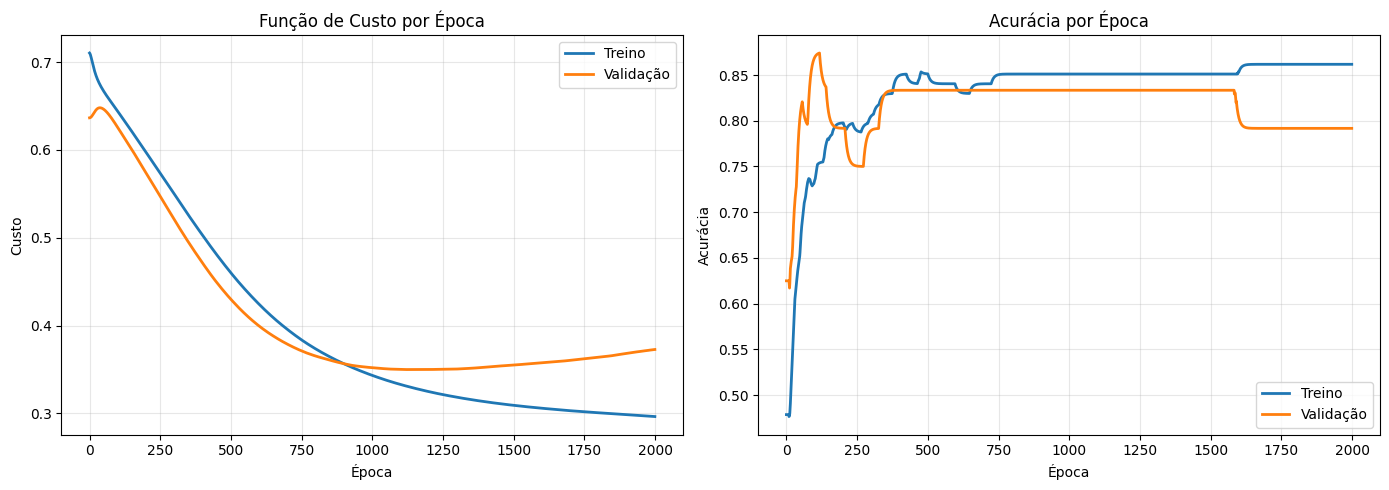

In [ ]:
# PLOT DOS RESULTADOS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Suaviza as curvas para visual
custo_smooth = smooth_curve(custo, 0.9)
custo2_smooth = smooth_curve(custo2, 0.9)
acc_smooth = smooth_curve(acc, 0.9)
acc_val_smooth = smooth_curve(acc_val, 0.9)

ax1.plot(custo_smooth, label='Treino', linewidth=2)
ax1.plot(custo2_smooth, label='Validação', linewidth=2)
ax1.set_xlabel('Época')
ax1.set_ylabel('Custo')
ax1.set_title('Função de Custo por Época')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(acc_smooth, label='Treino', linewidth=2)
ax2.plot(acc_val_smooth, label='Validação', linewidth=2)
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia')
ax2.set_title('Acurácia por Época')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Fronteira de decisão
- Plota a probabilidade estimada sobre um grid e desenha a linha de decisão (prob=0.5).
- Atenção: os eixos correspondem a *features normalizadas* (Z-score).


/tmp/ipython-input-2220401413.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[pos, 0], X[pos, 1], c='red', marker='+', s=150,


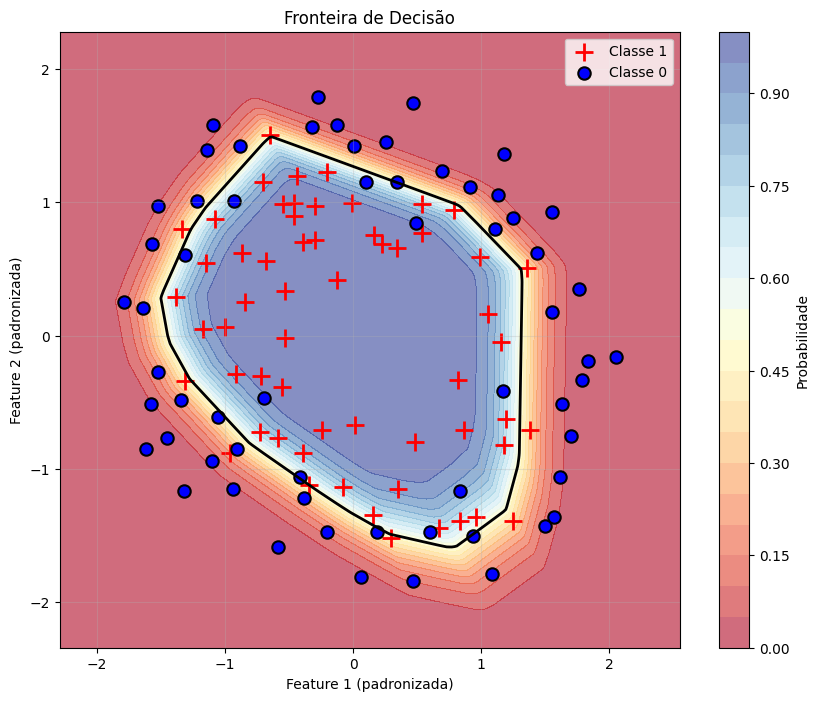

In [ ]:
# FUNÇÃO PARA PLOTAR FRONTEIRA DE DECISÃO
def plot_decision_boundary(net, X, y):
    # limites do grid (com margem)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    h_step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_step),
                         np.arange(y_min, y_max, h_step))

    # computa prob para cada ponto do grid
    Z = np.array([h(np.array([x1, x2]), net)
                  for x1, x2 in zip(xx.ravel(), yy.ravel())])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, levels=20, alpha=0.6, cmap='RdYlBu')
    plt.colorbar(label='Probabilidade')
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)  # fronteira prob=0.5

    pos = (y == 1)
    neg = (y == 0)
    plt.scatter(X[pos, 0], X[pos, 1], c='red', marker='+', s=150,
                label='Classe 1', edgecolors='black', linewidths=2)
    plt.scatter(X[neg, 0], X[neg, 1], c='blue', marker='o', s=80,
                label='Classe 0', edgecolors='black', linewidths=1.5)

    plt.xlabel('Feature 1 (padronizada)')
    plt.ylabel('Feature 2 (padronizada)')
    plt.title('Fronteira de Decisão')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plota a fronteira usando X e y (normalizados)
plot_decision_boundary(net, X, y)



--- TREINO ---
Matriz de Confusão:
[[39  6]
 [ 7 42]]
Acurácia: 0.8617 | Precisão: 0.8750 | Recall: 0.8571 | F1-Score: 0.8660

--- VALIDAÇÃO ---
Matriz de Confusão:
[[12  3]
 [ 2  7]]
Acurácia: 0.7917 | Precisão: 0.7000 | Recall: 0.7778 | F1-Score: 0.7368


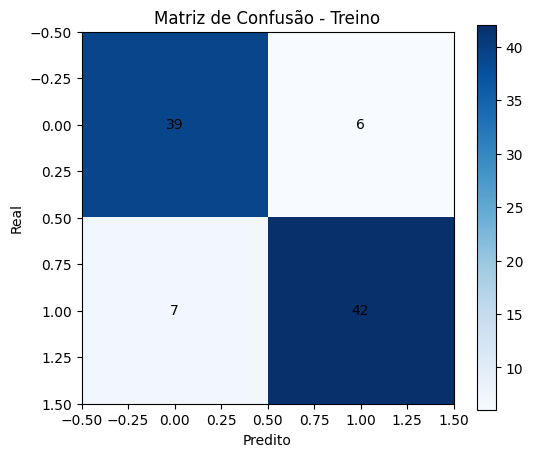

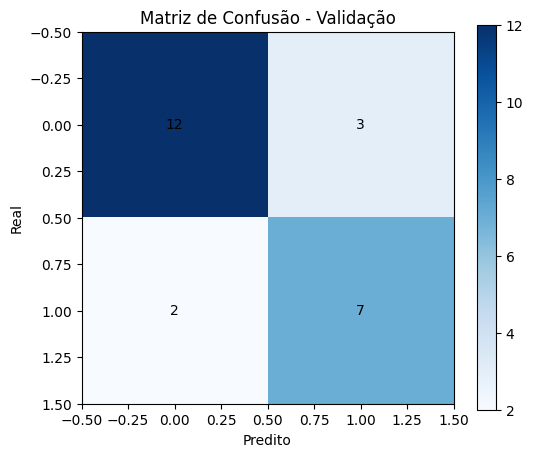

In [ ]:
def compute_metrics(y_true, y_pred):
    # Matriz de Confusão 2x2
    cm = np.zeros((2, 2), dtype=int)
    for real, pred in zip(y_true, y_pred):
        cm[real, pred] += 1

    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    accuracy_val = (TP + TN) / np.sum(cm)
    precisao = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precisao * recall / (precisao + recall) if (precisao + recall) > 0 else 0

    return cm, accuracy_val, precisao, recall, f1

# Predições treino
y_train_pred = np.array([classifica(h(x, net)) for x in X_train])
cm_train, acc_train, prec_train, rec_train, f1_train = compute_metrics(y_train, y_train_pred)

# Predições validação
y_val_pred = np.array([classifica(h(x, net)) for x in X_val])
cm_val, acc_val_final, prec_val, rec_val, f1_val = compute_metrics(y_val, y_val_pred)

# Mostra resultados
print("\n--- TREINO ---")
print("Matriz de Confusão:")
print(cm_train)
print(f"Acurácia: {acc_train:.4f} | Precisão: {prec_train:.4f} | Recall: {rec_train:.4f} | F1-Score: {f1_train:.4f}")

print("\n--- VALIDAÇÃO ---")
print("Matriz de Confusão:")
print(cm_val)
print(f"Acurácia: {acc_val_final:.4f} | Precisão: {prec_val:.4f} | Recall: {rec_val:.4f} | F1-Score: {f1_val:.4f}")

# Função para plotar matriz de confusão
def plot_cm(cm, title="Matriz de Confusão"):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predito")
    plt.ylabel("Real")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.show()

# Plot das matrizes
plot_cm(cm_train, "Matriz de Confusão - Treino")
plot_cm(cm_val, "Matriz de Confusão - Validação")

Validação do Cálculo do Gradiente

In [ ]:
# VALIDAÇÃO NUMÉRICA DO GRADIENTE - COD 1
def numerical_gradient_check(net, X, y, epsilon=1e-7, num_checks=10):
    """
    Valida o gradiente calculado pelo backprop usando aproximação numérica
    """
    print("\n" + "="*60)
    print("VALIDAÇÃO NUMÉRICA DO GRADIENTE (SEM REGULARIZAÇÃO)")
    print("="*60)

    # Calcula gradiente analítico via backprop
    # grad_analytical = backprop(net, X, y) --> estava calculando para todo o conjunto de dados

    # Seleciona alguns exemplos aleatórios para teste
    np.random.seed(42)
    indices = np.random.choice(len(X), min(num_checks, len(X)), replace=False)

    relative_errors = []

    # grad_analytical = backprop(net, x_sample.reshape(1, -1), np.array([y_sample]))

    for idx in indices:
        x_sample = X[idx]
        y_sample = y[idx] # problema comparando os erros amostrais com os

        grad_analytical = backprop(net, x_sample.reshape(1, -1), np.array([y_sample]))

        # Para cada parâmetro na rede, verifica gradiente
        for layer_idx in range(len(net)):
            for param in ['w', 'b']:
                param_shape = net[layer_idx][param].shape

                # Seleciona alguns elementos aleatórios para verificar
                if param == 'w':
                    i, j = np.random.randint(0, param_shape[0]), np.random.randint(0, param_shape[1])
                else:  # 'b'
                    i, j = np.random.randint(0, param_shape[0]), 0

                # Salva valor original
                original_value = net[layer_idx][param][i, j].copy()

                # Calcula J(theta + epsilon)
                net[layer_idx][param][i, j] = original_value + epsilon
                J_plus = cost(h(x_sample, net), y_sample)

                # Calcula J(theta - epsilon)
                net[layer_idx][param][i, j] = original_value - epsilon
                J_minus = cost(h(x_sample, net), y_sample)

                # Gradiente numérico
                grad_numerical = (J_plus - J_minus) / (2 * epsilon)

                # Gradiente analítico
                grad_analytical_val = grad_analytical[layer_idx][param][i, j]

                # Restaura valor original
                net[layer_idx][param][i, j] = original_value

                # Calcula erro relativo
                if abs(grad_numerical) > 1e-10 or abs(grad_analytical_val) > 1e-10:
                    relative_error = abs(grad_numerical - grad_analytical_val) / max(abs(grad_numerical), abs(grad_analytical_val))
                else:
                    relative_error = 0

                relative_errors.append(relative_error)

                print(f"Camada {layer_idx}, {param}[{i},{j}]: "
                      f"Analítico = {grad_analytical_val:10.6f}, "
                      f"Numérico = {grad_numerical:10.6f}, "
                      f"Erro Rel = {relative_error:8.2e}")

    # Estatísticas
    relative_errors = np.array(relative_errors)
    print(f"\nESTATÍSTICAS DA VALIDAÇÃO:")
    print(f"Erro relativo médio: {np.mean(relative_errors):.2e}")
    print(f"Erro relativo máximo: {np.max(relative_errors):.2e}")
    print(f"Erro relativo mínimo: {np.min(relative_errors):.2e}")
    print(f"Verificações realizadas: {len(relative_errors)}")

    # Critério de sucesso
    if np.mean(relative_errors) < 1e-7:
        print("✅ VALIDAÇÃO BEM-SUCEDIDA: Gradientes consistentes!")
    elif np.mean(relative_errors) < 1e-5:
        print("⚠️  VALIDAÇÃO ACEITÁVEL: Pequenas diferenças nos gradientes.")
    else:
        print("❌ VALIDAÇÃO FALHOU: Grandes diferenças nos gradientes!")

    return relative_errors

# Executa a validação
print("Executando validação numérica do gradiente...")
errors = numerical_gradient_check(net, X_train[:100], y_train[:100])  # Usa subset para velocidade

Executando validação numérica do gradiente...

VALIDAÇÃO NUMÉRICA DO GRADIENTE (SEM REGULARIZAÇÃO)
Camada 0, w[87,0]: Analítico =  -0.010233, Numérico =  -0.010233, Erro Rel = 1.80e-08
Camada 0, b[7,0]: Analítico =   0.000000, Numérico =   0.000000, Erro Rel = 0.00e+00
Camada 1, w[0,87]: Analítico =  -0.001056, Numérico =  -0.001056, Erro Rel = 8.76e-07
Camada 1, b[0,0]: Analítico =  -0.019861, Numérico =  -0.019861, Erro Rel = 1.12e-08
Camada 0, w[62,0]: Analítico =  -0.011084, Numérico =  -0.011084, Erro Rel = 7.04e-08
Camada 0, b[80,0]: Analítico =   0.000000, Numérico =   0.000000, Erro Rel = 0.00e+00
Camada 1, w[0,7]: Analítico =  -0.087607, Numérico =  -0.087607, Erro Rel = 9.33e-09
Camada 1, b[0,0]: Analítico =  -0.233894, Numérico =  -0.233894, Erro Rel = 1.21e-09
Camada 0, w[34,0]: Analítico =   0.000000, Numérico =   0.000000, Erro Rel = 0.00e+00
Camada 0, b[32,0]: Analítico =   0.000000, Numérico =   0.000000, Erro Rel = 0.00e+00
Camada 1, w[0,4]: Analítico =  -0.049977, Num